In [1]:
get_ipython().system('pip install gym pyvirtualdisplay > /dev/null 2>&1')
get_ipython().system('apt-get update ')
get_ipython().system('apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1')
get_ipython().system('apt-get install x11-utils')

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

v_display = Display(visible=0, size=(1400,900),)
v_display.start()

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 163 kB in 1s (119 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency t

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import gym
import torch
import numpy as np
import time
from collections import namedtuple

version = "1.0.0"

StepInfo = namedtuple("StepInfo", ("obs", "act_v", "noise_v", "act", "last_obs", "rew", "done", "etc", "n"))

class Agent:
    def __init__(self, env, actor, noise = None, max_step = None, device=None):
        self.env = env
        if max_step is not None:
            self.env._max_episode_steps = max_step           
        self.actor = actor
        self.noise = noise
        self.device = device
        
        self.wait = -1
        self.interval = -1
        self.frame = None
        
        self.step_set = False
        self.n_step = 1
        self.gamma = 0.99
        self.scale_factor = 1
        self.bias=0
        
    def prepare(self, step_unroll, gamma, cnn=False, scale=1, bias=0):
        self.step_set = True
        self.n_step = step_unroll
        self.gamma= gamma
        self.scale_factor = scale
        self.bias=bias
        self.cnn = cnn
        
    def set_renderer(self, rend_wait=0, rend_interval=1, frame = None):
        self.wait = rend_wait
        self.interval = rend_interval
        self.frame = frame
        
    def reset(self):
        self.env.close()
        self.env.reset()
        
    def render(self, epoch):
        if self.wait >= 0 and epoch < self.wait:
            return
        if self.interval >= 0 and epoch % self.interval == 0:
            rend = self.env.render("rgb_array")
            if self.frame is not None:
                self.frame.append(self.env.render("rgb_array"))
        
    def episode(self, epoch):
        assert self.step_set
        t=time.time()
        buffer = []
        self.obs = self.env.reset()
        if self.cnn:
            self.obs = self.actor.convert_input(self.env.render("rgb_array"))
        else:
            self.render(epoch)

        total_rew = 0
        total_rew_scaled = 0
        count = 0
        while True:
            with torch.no_grad():
                out = self.actor(torch.FloatTensor([self.obs]).to(self.device))
                act_v = out[0] if type(out) is tuple else out
                act_v = act_v.cpu().squeeze(0).numpy()
                if self.noise is not None:
                    noise_v = act_v + self.noise.get_noise()
                else:
                    noise_v = act_v
                if self.env.action_space.shape:
                    noise_v = noise_v.clip(self.env.action_space.low, self.env.action_space.high)
                act = self.actor.convert_to_action(noise_v)

            next_obs, rew, done, etc = self.env.step(act)
            obs = self.obs
            if self.cnn:
                next_obs = self.actor.convert_input(self.env.render("rgb_array"))
            else:
                self.render(epoch)
            self.obs = next_obs
            count += 1

            total_rew_scaled += rew
            rew += self.bias
            rew /= self.scale_factor
            total_rew += rew

            buffer.append(StepInfo(obs, act_v, noise_v, act, next_obs, rew, done, etc, -1))
            if done:
                break
                
            if len(buffer) < self.n_step:
                continue
                
            yield self.unroll_step(buffer)
            buffer.pop(0)
            
        while len(buffer):
            yield self.unroll_step(buffer)
            buffer.pop(0)
        print("ep#%4d]"%epoch, "elapsed : %.2f, count : %4d, scaled_rew : %03.5f, total_rew : %03.5f"%(time.time()-t, count, total_rew, total_rew_scaled))
        return

    def unroll_step(self, buffer):
        assert len(buffer)
        
        rews = list(map(lambda b:b.rew, buffer))
        rews.reverse()
        rew_sum = 0

        for r in rews:
            rew_sum*=self.gamma
            rew_sum+=r
            
        done = buffer[-1].done if len(buffer) == self.n_step else True
        return StepInfo(buffer[0].obs, buffer[0].act_v, buffer[0].noise_v, buffer[0].act, buffer[-1].last_obs, rew_sum, done, buffer[0].etc, len(buffer))

import numpy as np
import math

class NoiseMaker():
    def __init__(self, action_size, n_type = None, param = None, decay = True):
        self.action_size = action_size
        self.state = np.zeros(action_size, dtype=np.float32)
        self.count = 0
        self.decay = decay
        if n_type is None:
            n_type = "normal"
        self.type = n_type
        
        if param is None:
            self.param = {
                "start": 0.9,
                "end":0.02,
                "decay": 2000
            }
            if n_type =="ou":
                self.param["ou_mu"] = 0.0
                self.param["ou_th"] = 0.15
                self.param["ou_sig"] = 0.2
        else:
            self.param = param
            
    def get_noise(self):
        eps = self.param["end"] + (self.param["start"] - self.param["end"]) * math.exp(-1*self.count/ self.param["decay"])
        
        noise = np.random.normal(size=self.action_size)
        if self.type == "ou":
            self.state += self.param["ou_th"] * (self.param["ou_mu"] - self.state) + self.param["ou_sig"] * noise
            noise = self.state
        if not self.decay:
            eps = 1
        self.count += 1
            
        return noise * eps

import collections
import random
import numpy as np
import math

class Replay:
    def __init__(self, init, size, prio = False, alph = 0.6, beta = 0.4):
        self.memory = collections.deque(maxlen = size)
        self.init = init
        self.size = size
        self.priorities = collections.deque(maxlen = size)
        self.prio = prio
        self.alph = alph if prio else 0
        self.beta = beta if prio else 0
        self.count = 0
        self.prepared = False
        
    def push(self, data):
        self.memory.append(data)
        self.count += 1
        if self.prio:
            max_prio = np.array(self.priorities).max() if len(self.priorities) else 1.
            self.priorities.append(max_prio)
        
    def is_ready(self):
        ret = len(self) >= self.init
        if ret and not self.prepared:
            self.prepared = True
            print("replay memory is ready!")
        return ret
        
    def sample(self, size):
        if self.prio:
            probs = np.array(self.priorities, dtype=np.float32)
            min_prio = np.array(self.priorities).min()
            if min_prio < 1:
                probs /= min_prio
            probs = probs ** self.alph
            probs /= probs.sum()
        else:
            probs = np.ones(len(self),) / len(self)
        
        indices = np.random.choice(len(self), size, p=probs)
        sample = [self.memory[idx] for idx in indices]
        
        beta = 1. + (self.beta - 1.) * math.exp(-1 * self.count / self.size)
        weights = (len(self) * probs[indices]) ** (-beta)
        weights /= weights.sum()
        
        return sample, indices, weights
        
    def update_priorities(self, indices, prios):
        if not self.prio:
            return
        prios += 1e-8
        for idx, prio in zip(indices,prios):
            self.priorities[idx] = prio
    
    def __len__(self):
        return len(self.memory)
    
import torch.nn as nn
import copy

class targetNet(nn.Module):
    def __init__(self, off_net):
        super(targetNet, self).__init__()
        self.net = copy.deepcopy(off_net)
        self.off_net = off_net
        
    def alpha_update(self, alpha = 0.05):
        for off, tgt in zip(self.off_net.parameters(), self.net.parameters()):
            tgt.data.copy_(off.data*alpha + tgt.data*(1-alpha))
    
    def copy_off_net(self):
        self.net.load_state_dict(self.off_net.state_dict())
    
    def forward(self, *x):
        return self.net(*x)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class Actor(nn.Module):
    def __init__(self, act_n, shape, hidden = 512):
        super(Actor, self).__init__()
        cnn_out_channel = 64
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, cnn_out_channel, 4, 2, 1),
            nn.ReLU()
        )
        
        w = self.get_conv_out_size(shape[1])
        h = self.get_conv_out_size(shape[2])
        self.cnn_out = w*h*cnn_out_channel
        
        self.actor = nn.Sequential(
            nn.Linear(self.cnn_out, hidden),
            nn.ReLU(),
            nn.Linear(hidden, int(hidden/2)),
            nn.ReLU(),
            nn.Linear(int(hidden/2), act_n),
            nn.Tanh()
        )
    
    def to(self, device):
        self.device = device
        return super(Actor,self).to(device)
        
    def convert_input(self, x):
        return x[165:330].transpose(2,0,1)/255
        
    def convert_to_action(self, act_v):
        return act_v.argmax()
        
    def get_conv_out_size(self, value):
        return int(int(int(value/2)/2)/2)
    
    def forward(self, x):
        cnn_out = self.cnn(x).view(-1,self.cnn_out)
        return self.actor(cnn_out)

In [0]:
class Critic(nn.Module):
    def __init__(self, act_n, shape, hidden = 512):
        super(Critic, self).__init__()
        cnn_out_channel = 64
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, cnn_out_channel, 4, 2, 1),
            nn.ReLU()
        )
        
        w = self.get_conv_out_size(shape[1])
        h = self.get_conv_out_size(shape[2])
        self.cnn_out = w*h*cnn_out_channel
        
        self.critic = nn.Sequential(
            nn.Linear(self.cnn_out, hidden),
            nn.ReLU(),
        )
        self.critic_out = nn.Sequential(
            nn.Linear(hidden + act_n, int(hidden/2)),
            nn.ReLU(),
            nn.Linear(int(hidden/2), 1)
        )
    
    def to(self, device):
        self.device = device
        return super(Critic,self).to(device)
        
    def get_conv_out_size(self, value):
        return int(int(int(value/2)/2)/2)
    
    def forward(self, x, act_v=None):
        cnn_out = self.cnn(x).view(-1,self.cnn_out)
        return self.critic_out(torch.cat([self.critic(cnn_out), act_v],dim=1))

In [6]:
env = gym.make("CartPole-v0")
act_n = env.action_space.n
obs_n = env.observation_space.shape[0]

env.reset()
r = (env.render("rgb_array")[165:330].transpose(2,0,1))
env.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
import matplotlib.pyplot as plt

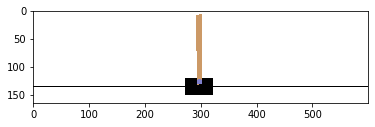

In [8]:
plt.imshow(r.transpose(1,2,0))

In [0]:
LR = 0.001

device = "cuda:0" if torch.cuda.is_available() else "cpu"

actor= Actor(act_n, r.shape).to(device)
actor_tgt = targetNet(actor)
actor_opt = optim.Adam(actor.parameters(), LR)
critic= Critic(act_n, r.shape).to(device)
critic_tgt = targetNet(critic)
critic_opt = optim.Adam(critic.parameters(), LR)

ST_SIZE = 10000
ST_INIT = 2000
ST_DECAY = 2000
ST_BATCH = 64
storage = Replay(ST_INIT, ST_SIZE, True)

GAMMA = 0.99

noise = NoiseMaker(act_n, "normal", decay = True)
agent = Agent(env, actor, noise, 400, device=device)
agent.prepare(3, GAMMA, True)


In [10]:
EPOCH = 1000
for epoch in range(EPOCH):
    for step in agent.episode(epoch):
        storage.push(step)
        if not storage.is_ready():
            continue
        
        sample, indices, weights = storage.sample(ST_BATCH)
        weights_ = torch.FloatTensor(weights).unsqueeze(1).to(device)
        obs, act_v, noise_v, act, next_obs, rew, done, etc, unroll_n = list(zip(*sample))
        
        obs_ = torch.FloatTensor(obs).to(device)
        act_v_ = torch.FloatTensor(act_v).to(device)
        noise_v_ = torch.FloatTensor(noise_v).to(device)
        act_ = torch.LongTensor(act).unsqueeze(1).to(device)
        next_obs_ = torch.FloatTensor(next_obs).to(device)
        rew_ = torch.FloatTensor(rew).unsqueeze(1).to(device)
        done_ = torch.BoolTensor(done).to(device)
        unroll_n_ = torch.FloatTensor(unroll_n).unsqueeze(1).to(device)

        #critic
        critic_opt.zero_grad()
        q_pred = critic(obs_, noise_v_)
        
        q_next = critic_tgt(next_obs_, actor_tgt(next_obs_))
        q_next[done_] = 0.
        q_target = rew_ + (GAMMA ** unroll_n_) * q_next.detach()
        
        q_diff = (q_pred - q_target) ** 2
        critic_loss = (weights_ * q_diff).sum()
        critic_loss.backward()
        critic_opt.step()
        
        storage.update_priorities(indices, q_diff.detach().cpu().numpy())
        
        #actor
        actor_opt.zero_grad()
        st_decay = torch.exp_(-torch.FloatTensor(len(storage)-indices)/ST_DECAY).unsqueeze(1).to(device)
        act_avg = actor(obs_) * (1-st_decay) + act_v_ * st_decay

        q_v = -critic(obs_, act_avg)

        actor_loss = q_v.mean()
        actor_loss.backward()
        actor_opt.step()
        
        #target_update
        actor_tgt.alpha_update()
        critic_tgt.alpha_update()

ep#   0] elapsed : 0.54, count :   14, scaled_rew : 14.00000, total_rew : 14.00000
ep#   1] elapsed : 1.22, count :   36, scaled_rew : 36.00000, total_rew : 36.00000
ep#   2] elapsed : 0.48, count :   14, scaled_rew : 14.00000, total_rew : 14.00000
ep#   3] elapsed : 0.54, count :   16, scaled_rew : 16.00000, total_rew : 16.00000
ep#   4] elapsed : 1.38, count :   41, scaled_rew : 41.00000, total_rew : 41.00000
ep#   5] elapsed : 0.99, count :   28, scaled_rew : 28.00000, total_rew : 28.00000
ep#   6] elapsed : 0.42, count :   12, scaled_rew : 12.00000, total_rew : 12.00000
ep#   7] elapsed : 0.52, count :   15, scaled_rew : 15.00000, total_rew : 15.00000
ep#   8] elapsed : 0.50, count :   15, scaled_rew : 15.00000, total_rew : 15.00000
ep#   9] elapsed : 0.48, count :   14, scaled_rew : 14.00000, total_rew : 14.00000
ep#  10] elapsed : 0.49, count :   14, scaled_rew : 14.00000, total_rew : 14.00000
ep#  11] elapsed : 0.92, count :   27, scaled_rew : 27.00000, total_rew : 27.00000
ep# 

KeyboardInterrupt: ignored

In [0]:
        critic_opt.zero_grad()
        actor_opt.zero_grad()
        st_decay = torch.exp_(-torch.FloatTensor(len(storage)-indices)/ST_DECAY).unsqueeze(1).to(device)
        act_avg = actor(obs_) * (1-st_decay) + act_v_ * st_decay

        q_v = -critic(obs_, actor(obs_))

        actor_loss = q_v.mean()
        actor_loss.backward()